# Periodicity Analysis

To verify whether periodicity in the Covid-19 data from the Uk is a product of the reporting process, or due to some phenomenan in the underlying processes.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import fftpack
import matplotlib.pyplot as plt
from phe_api import retrieve_data

import periodic_sampling as ps

In [2]:
# Read in data

df = pd.DataFrame(retrieve_data(area_name='england', area_type='nation'))
df["Date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")
df.sort_values(by="Date", inplace=True)
df = df[df["Date"] < "2022-02-01"]
print(df.columns.values)

['date' 'areaCode' 'newCasesByPublishDate' 'newCasesBySpecimenDate'
 'newDeaths28DaysByDeathDate' 'newDeaths28DaysByPublishDate'
 'newVirusTestsBySpecimenDate' 'Date']


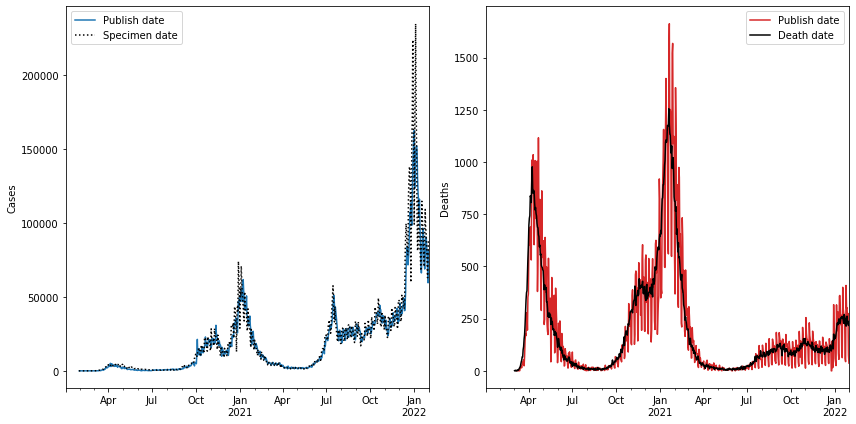

In [3]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(1, 2, figsize=(12,6))

plot1 = df.plot.line('Date', 'newCasesByPublishDate', ax=axs[0], color='tab:blue', label='Publish date')
plot1 = df.plot.line('Date', 'newCasesBySpecimenDate', ax=axs[0], color='black', linestyle=':', label = 'Specimen date')
axs[0].set_xlabel(''); axs[0].set_ylabel('Cases')

plot2 = df.plot.line('Date', 'newDeaths28DaysByPublishDate', ax=axs[1], color='tab:red', label = 'Publish date')
plot2 = df.plot.line('Date', 'newDeaths28DaysByDeathDate', ax=axs[1], color='black', label = 'Death date')
axs[1].set_xlabel(''); axs[1].set_ylabel('Deaths')

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/new_cases_and_deaths.png")


In [4]:
# Plot Fourier components of case data

def fourier_transform(df, column, compute_psd = False):
    data = df[column].fillna(0).values
    data_fft = sp.fftpack.fft(data)
    data_psd = np.abs(data_fft) ** 2  # Power Spectral density

    fftfreq = sp.fftpack.fftfreq(len(data_fft), 1/7)  # Frequency units in weeks
    return (data_psd, fftfreq) if compute_psd else (data_fft, fftfreq)

def plot_fft(data, freq, ax, color, label, alpha = 1):
    i = freq > 0  # Remove negative frequencies
    ax.plot(freq[i], 10 * np.log10(data[i]), color=color, alpha=alpha, label=label)
    y_lim = ax.get_ylim()
    ax.vlines([(n+1) for n in range(3)], y_lim[0], y_lim[1],
              colors='gray', linestyles='dashed', alpha=0.6)
    # ax.axvspan(0, 0.9, facecolor='gray', alpha=0.3)
    ax.set_xlabel('Frequency (1/week)')
    ax.set_ylabel('PSD (dB)')
    ax.legend(loc=3); ax.set_xlim((0, max(freq[i])))


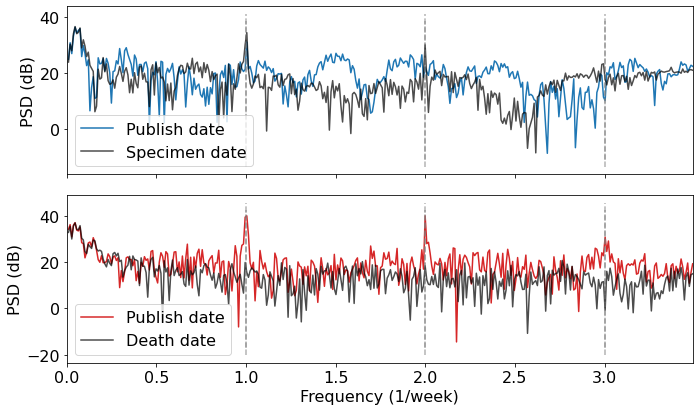

In [5]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)
df = ps.analysis.rel_reporting_calc(df, ['newCasesByPublishDate', 'newCasesBySpecimenDate',
                             'newDeaths28DaysByDeathDate', 'newDeaths28DaysByPublishDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesByPublishDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Publish date")
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='black', alpha=0.7, label="Specimen date")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_newDeaths28DaysByPublishDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='tab:red', label="Publish date")
death_fft_cert, death_freq_cert = fourier_transform(df, column='Dif_newDeaths28DaysByDeathDate', compute_psd=True)
plot_fft(death_fft_cert, death_freq_cert, ax=axs[1], color='black', alpha=0.7, label="Death date")

fig.patch.set_facecolor('white'); fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_cases_deaths.png")


## Weekly Patterns
We can identify periodic, weekly variation in the observed reporting factor.

In [6]:
summary = df.groupby('Weekday').median().sort_values('Day_Index')
print(summary[['Dif_newCasesByPublishDate', 'Dif_newCasesBySpecimenDate', 'Dif_newDeaths28DaysByPublishDate', 'Dif_newDeaths28DaysByDeathDate']])

           Dif_newCasesByPublishDate  Dif_newCasesBySpecimenDate  \
Weekday                                                            
Monday                      0.916211                    1.186588   
Tuesday                     0.962527                    1.134457   
Wednesday                   1.029357                    1.128155   
Thursday                    1.119377                    1.058374   
Friday                      1.096452                    0.972820   
Saturday                    1.029980                    0.782078   
Sunday                      0.943675                    0.834118   

           Dif_newDeaths28DaysByPublishDate  Dif_newDeaths28DaysByDeathDate  
Weekday                                                                      
Monday                             0.355932                        0.996666  
Tuesday                            1.458118                        1.004950  
Wednesday                          1.313793                        0.977941

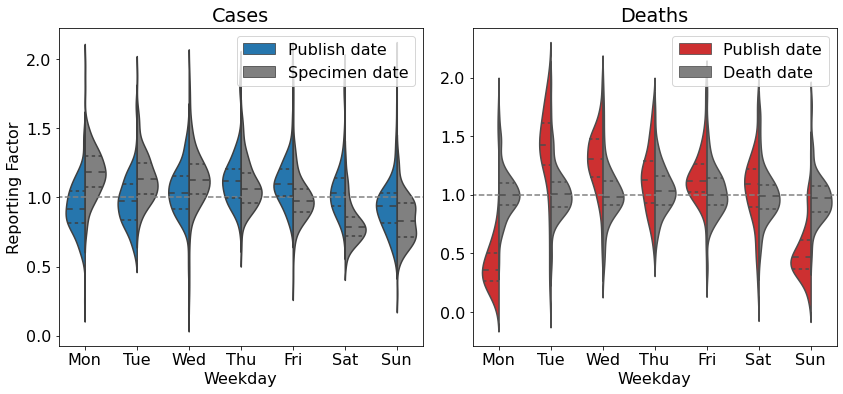

In [7]:
# separate violin for cases and deaths 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesByPublishDate', 'newCasesBySpecimenDate'],  ax=axs[0], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Publish date", "Specimen date"])  
ps.analysis.rel_reporting_violin(df.copy(), ['newDeaths28DaysByPublishDate', 'newDeaths28DaysByDeathDate'],  ax=axs[1], cutoff=2,
                   colors=['tab:red', 'grey'], labels=["Publish date", "Death date"])
for i in range(2):
    axs[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); axs[0].set_ylabel("Reporting Factor"); axs[1].set_ylabel("")
axs[0].set_title('Cases'); axs[1].set_title('Deaths')
plt.suptitle(''); fig.patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_violin_cases_deaths.png")

## Positivity Rates

There is still a weekly bias in positive tests by specimen date. Is this purely due to biases in the number of tests taken on a given day, or are there other factors at play here?

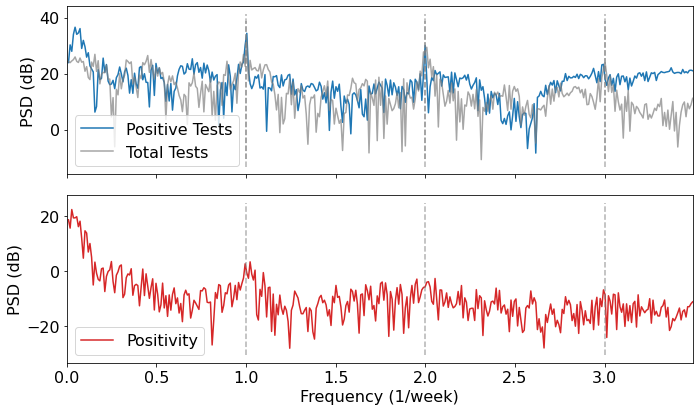

In [8]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df['positivityBySpecimenDate'] = df['newCasesBySpecimenDate'] / df['newVirusTestsBySpecimenDate']
df = ps.analysis.rel_reporting_calc(df, ['newVirusTestsBySpecimenDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Positive Tests")
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newVirusTestsBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='grey', alpha=0.7, label="Total Tests")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='positivityBySpecimenDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='tab:red', label="Positivity")

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_cases_deaths.png")


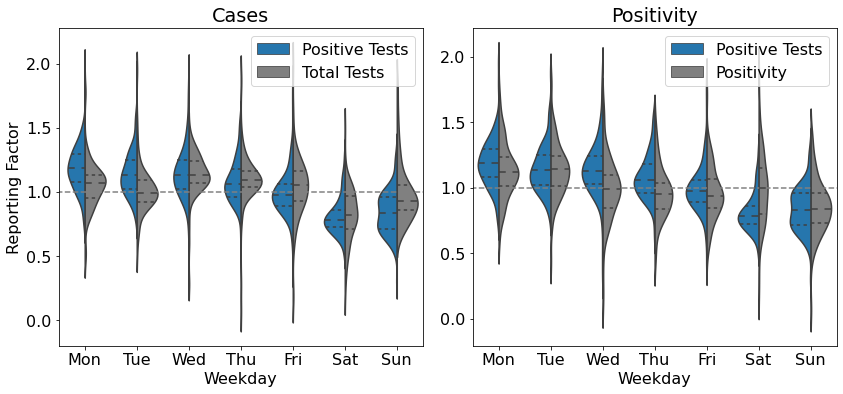

In [9]:
# separate violin for cases and deaths 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesBySpecimenDate', 'newVirusTestsBySpecimenDate'],  ax=axs[0], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Positive Tests", "Total Tests"])  
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesBySpecimenDate', 'positivityBySpecimenDate'],  ax=axs[1], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Positive Tests", "Positivity"])
for i in range(2):
    axs[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); axs[0].set_ylabel("Reporting Factor"); axs[1].set_ylabel("")
axs[0].set_title('Cases'); axs[1].set_title('Positivity')
plt.suptitle(''); plt.tight_layout()
plt.savefig(f"../images/uk_phe_data/daily_violin_cases_deaths.png")

In [10]:
# two way anove test to test significance for this?